In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from joblib import dump,load
from sklearn.preprocessing import StandardScaler
# Import scoring metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [46]:
df_temp = pd.read_pickle('./clean_data/clean_data_dataframe.zip')

In [57]:
# Define a 'basic' dataframe that only predicts off LendingClub sub_grade feature
df_basic= df_temp[['loan_status','sub_grade']]

# Select a grade to look at 

# Only look at low grades, high interest
#df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('B' in element))]

df_temp.drop(columns = 'sub_grade', inplace = True)

In [45]:
# Load models
model_filepath = './models/'
rfc = load('../rfc_model/rfc.pkl')
lm = load(model_filepath + 'lm.pkl')
gbc = load(model_filepath + 'gbc.pkl')


In [58]:
# Helper functions
def patsy_string_from_df(df,target_string):
    """Makes patsy string from dataframe df. Drops target_string column by default."""
    df = df.drop(columns = [target_string]) # Drop the target variable
    patsy_string = ''
    for title in df.columns:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    # print("Patsy String: " +patsy_string)
    return patsy_string

def make_confusion_matrix(model, X_test , y_test, threshold=.5, plot = False):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    mat_confusion = confusion_matrix(y_test, y_predict)

    if plot:
        plt.figure(dpi=80)
        plt.figure(figsize=(8, 8))
        sns.heatmap(mat_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
               xticklabels=['Paid off', 'Defaulted'],
               yticklabels=['Paid off', 'Defaulted']);
        plt.xlabel('prediction')
        plt.ylabel('actual')
        plt.title(str(type(model)))
    return mat_confusion




In [59]:
X = patsy.dmatrix(patsy_string_from_df(df_temp,'loan_status'),df_temp)
y = df_temp['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)
# Standardize for models that nead standardization variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

# Standardize all for simplicity
X_train = X_train_standard
X_test = X_test_standard


array([[19001, 15250],
       [ 1766,  5816]])

<Figure size 480x320 with 0 Axes>

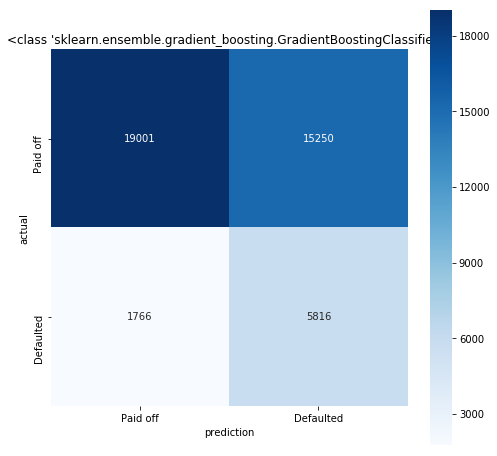

In [60]:
make_confusion_matrix(gbc, X_test, y_test, threshold = .15,plot = True)

# Cost function to optimize threshold

(Loans classified as defaulted but fully paid off * average paid off loan amount ) - 
(loans classified as paid off but defaulted * average loss to defaulted loan amount)



In [ ]:


df = pd.read_pickle('./data/loan_data_2014.zip',compression = 'zip')
df = df.loc[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
df.shape

df_gain = df.loc[df['loan_status'] == 'Fully Paid']

# How much does LC fund their loans?

df_lc_funds = (df_gain.loc[df_gain['loan_amnt'] != df_gain['funded_amnt_inv']])
df_lc_funds['lc_funds']= df_lc_funds['funded_amnt'] - df_lc_funds['funded_amnt_inv']
print('LC average contribution to loans: ' + str(df_lc_funds['lc_funds'].mean()))
print('LC total contributions to loans: ' + str(df_lc_funds['lc_funds'].mean()*df_lc_funds.shape[0]))

# # Find Average gains and losses on misclassified loans

# Find average gains per successful loan
df_gain = df.loc[df['loan_status'] == 'Fully Paid']
df_gain = df_gain[['loan_amnt',
        'total_pymnt',
        'total_rec_int',
        'total_rec_late_fee',
        'total_rec_prncp','total_pymnt_inv']]
df_gain['total_gain'] = df_gain['total_rec_int'] + df_gain['total_rec_late_fee']
average_gain_per_successful_loan = df_gain['total_rec_int'].mean()


# In[102]:


# Find average loss per charged off loan
df_loss=df.loc[df['loan_status'] == 'Charged Off']
df_loss = df[['loan_amnt',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    'settlement_amount']]
df_loss['settlement_amount'].fillna(0,inplace = True)
df_loss['total_recovered'] = df_loss['total_rec_int'] +\
                            df_loss['total_rec_late_fee'] + \
                            df_loss['total_rec_late_fee'] +\
                            df_loss['total_rec_prncp'] +\
                            df_loss['settlement_amount']
df_loss['percent_recovered'] = df_loss['total_recovered'] / df_loss['loan_amnt']
average_loss_per_unsuccessful_loan = df_loss['total_recovered'].mean()


# # Test 1: Use F1_SCORE and for loop to find best threshold in rf model
# 

def find_best_threshold(model, int_num_steps,X_test,y_test, metric):
    best_threshold = 0    
    if metric == 'f1':
        highest_f1 = 0
        for threshold in np.linspace (0, 1, int_num_steps):
            y_predict = (model.predict_proba(X_test)[:, 1] >= threshold) 
            f1 = f1_score(y_test,y_predict)
            if f1 > highest_f1:
                best_threshold, highest_f1 = threshold, f1
        return best_threshold, highest_f1;
    if metric == 'loan':
        highest_profit = -1
        model_profit = -1
        current_investor_profit = 0
        for threshold in np.linspace(0,1, int_num_steps):
            # Positive in this case is classified as charged off
            cm = make_confusion_matrix(model,X_test,y_test, threshold)
            false_positive = cm[0][1]
            false_negative = cm[1][0]
            true_positive = cm[1][1]
            true_negative = cm[0][0]
            model_profit = false_positive * average_gain_per_successful_loan +\
                        false_negative * average_loss_per_unsuccessful_loan
            
            rel_model_profit = average_gain_per_successful_loan * true_negative +\
                    average_loss_per_unsuccessful_loan * true_positive -\
                    (average_gain_per_successful_loan * false_positive +\
                    average_loss_per_unsuccessful_loan * false_negative)
            model_profit = true_negative * average_gain_per_successful_loan -\
                            false_negative * average_loss_per_unsuccessful_loan
            
            if highest_profit < 0:
                highest_profit = model_profit
            elif model_profit > highest_profit:
                highest_profit = model_profit
                best_threshold = threshold

                print("better model_profit: " + str(model_profit))
            if not current_investor_profit:
                current_investor_profit = average_gain_per_successful_loan * (true_negative + false_positive) -\
                                    (average_loss_per_unsuccessful_loan * (false_negative + true_positive))
                print("current_investor_profit: " + str(current_investor_profit))
        return best_threshold, highest_profit

best_thresh, highest_profit = find_best_threshold(gbc,20,X_test_standard,y_test, metric = 'loan')

make_confusion_matrix(gbc,X_test, y_test ,best_thresh,plot = True)
print('Best Threshold: ', best_thresh)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


LC average contribution to loans: 66.42326075411577
LC total contributions to loans: 875525.0


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


current_investor_profit: -20478746.62011756
better model_profit: 10247403.44663516
better model_profit: 23733424.72201605
better model_profit: 27423347.47333522
